## Time-Series Forecasting / Modelling

Table of contents:

0. Task Overview
1. Data Import
2. Exploratory Data Analysis (EDA)
3. Baseline (naive) Forecasting
4. Checking TS properties
5. Autoregressive Model (AR)
6. Moving Average Model (MA)
7. Autoregressive Moving Average Model (ARMA)
8. Linear Regression / ElasticNet

This notebook demonstrates a couple of methods to predict the share price movements of two stocks, Goldman Sachs (ticker: GS) and JP Morgan (ticker: JPM), using traditional time-series models and a regularised variation of linear regression (Elastic Net).

First, to establish a baseline, we are going to make a naive prediction; that is, we're going to assume that all future prices are the same as the last known price. After that, we'll introduce some basic models: Autoregressive (AR), Moving average (MA) and their combination, ARMA. Finally, we will check if linear regression coupled with polynomial features could improve our results.

Data used: Daily closing trading prices were used covering more than 2 years.

#### 1. Data Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from itertools import product
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# I am using yfinance to source the data; alternatively, it is available at https://uk.finance.yahoo.com/
import yfinance as yf

date_start = '2020-01-01'
date_end = '2022-03-10'
gs = yf.download('GS', start=date_start, end=date_end)
jpm = yf.download('JPM', start=date_start, end=date_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### 2. Exploratory Data Analysis (EDA)

The data fetched from Yahoo requires no cleansing; there is no missing data point and the data types are automatically set to numerical (float64) indicating that there is nothing non-numerical added by mistake.

In [2]:
print('First date - Last date:')
print(f'GS: {min(gs.index.date)} : {max(gs.index.date)}')
print(f'JPM: {min(jpm.index.date)} : {max(jpm.index.date)}')

print('\nNumber of observations / unique dates:')
print(f'GS: {len(gs.Close)} / {gs.index.nunique()}')
print(f'JPM: {len(jpm.Close)} / {jpm.index.nunique()}')

print('\nNumber of missing data points (N/A):')
print(f'GS: {gs.Close.isna().sum()}')
print(f'JPM: {jpm.Close.isna().sum()}')

print('\nData type is numerical?')
print(f'GS: {pd.api.types.is_numeric_dtype(gs.Close.dtype)}')
print(f'GS: {pd.api.types.is_numeric_dtype(jpm.Close.dtype)}')

First date - Last date:
GS: 2020-01-02 : 2022-03-09
JPM: 2020-01-02 : 2022-03-09

Number of observations / unique dates:
GS: 551 / 551
JPM: 551 / 551

Number of missing data points (N/A):
GS: 0
JPM: 0

Data type is numerical?
GS: True
GS: True


By plotting the stock prices we can get a quick insight into how they performed over the last two years. As expected, both JPM and GS stock prices dropped sharply in March 2020 due to the COVID shock. After that there was a smaller rebound and a few months of a sideways trend, followed by a sharp increase in the prices of both stocks. This lasted until the second half of 2021 thanks, in part, to the successful vaccination rollout, various stimulus packages, and generally a supportive economic environment. At the end of last year, the prospect of a tighter monetary policy started to dent optimism and then in Q1 this year the Russia-Ukraine conflict has taken a massive toll on the markets leading to sharply dropping prices noticable in both GS and JPM stock prices.

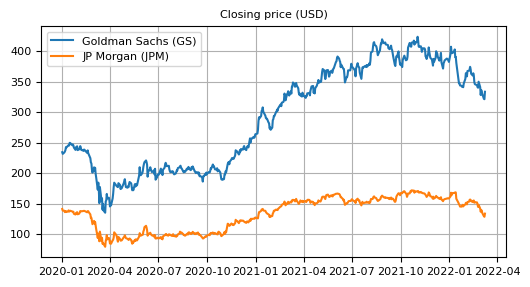

In [3]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,3)
plt.plot(gs['Close'], label='Goldman Sachs (GS)')
plt.plot(jpm['Close'], label='JP Morgan (JPM)')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.title('Closing price (USD)', fontsize=8)
plt.legend(loc='upper left', fontsize=8);

The top left chart shows the range of price ratios the stocks have spanned since the beginning of 2020. The ratios are calculated relative to the first day of our period (2nd Jan, 2020). It shows that GS's price covered a lot wider range, appreciating by up to 80% relative to its original value at the beginning of the period. In contrast, JPM has not appreciated even by 30% at any point during the same period. In terms of max drawdowns, however, they both exhibit similar values in the region of -40%.

The top right chart shows daily return volatilities averaged over a 50-day rolling window. In general, the two stocks exhibit very similar levels of volatility although JPM had a period of markedly higher relative volatility at the end of 2020 / early 2021. Overall, there is not too much between two, which is confirmed by volatilities calculated for the entire period: GS 2.54% vs JPM 2.57% (daily).

The chart at the bottom is a histogram showing the daily return distribution for the two stocks coupled with their respective Gaussian density estimation (Kernel Density Estimation, KDE). Again, there is not too much difference between the two; they both exhibit the usual patterns of stock returns; that is, they broadly follow a normal distribution, however, with a higher percentage of values falling around the mean (i.e. positive kurtosis, leptokurtic) and far away from that (i.e. fat tails).

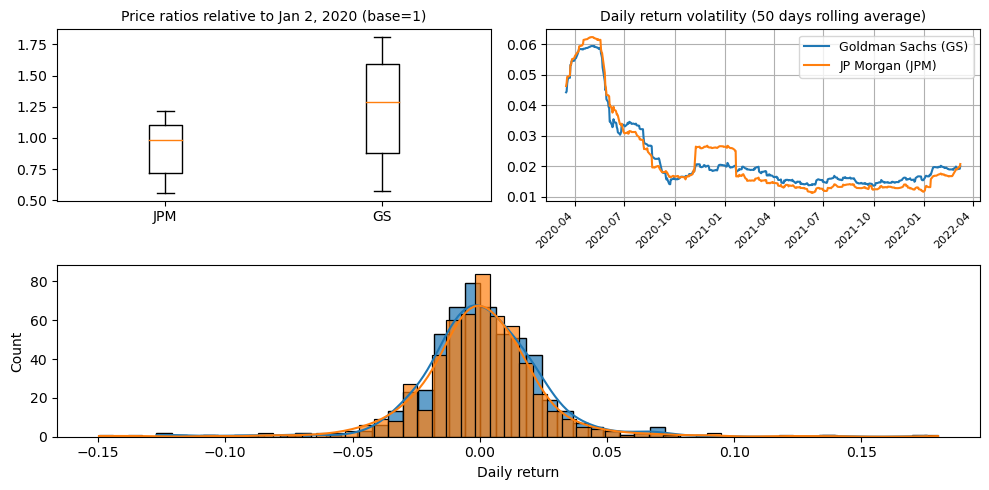

In [4]:
import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%m')

# create figures and axes
fig=plt.figure(figsize=(10,5))
ax0 = plt.subplot2grid((2,2),(0,0))
ax1 = plt.subplot2grid((2,2),(0,1))
ax2 = plt.subplot2grid((2,2),(1,0), colspan=2)

# boxplot
ax0.boxplot([jpm.Close / jpm.Close[0], gs.Close / gs.Close[0]], labels=['JPM', 'GS'])
ax0.set_title('Price ratios relative to Jan 2, 2020 (base=1)', fontsize=10)

# line chart
for stock, name in zip([gs, jpm], ['Goldman Sachs (GS)', 'JP Morgan (JPM)']):
    ax1.plot(stock.Close.pct_change().rolling(50).agg(np.std), label=name)

ax1.grid()
ax1.set_title('Daily return volatility (50 days rolling average)', fontsize=10)
ax1.set_xticklabels(ax1.get_xticks(), rotation=45, ha='right', fontsize=8)
ax1.xaxis.set_major_formatter(date_format)
ax1.legend(loc='upper right', fontsize=9);

# histogram
sns.histplot(gs.Close.pct_change(), kde=True, alpha=0.7,
             color='#1f77b4', label='Goldman Sachs (GS)',
             ax=ax2)
sns.histplot(jpm.Close.pct_change(), kde=True, alpha=0.7,
             color='#ff7f0e', label='JP Morgan (JPM)',
             ax=ax2)

ax2.set_xlabel('Daily return', fontsize=10)

plt.tight_layout()

#### 3. Baseline estimate - naive forecasting

To have something to compare the time series models' performance against, a baseline prediction is set for all out-of-sample dates as being the same as the last known in-sample price.

There are multiple metrics we can use to evaluate our forecasts, each with its own pros and cons. To keep it simple, I will be using two metrics: the root mean squared error (RMSE) and mean absolute percentage error (MAPE).

The length of out-of-sample prediction is set to 30 days.

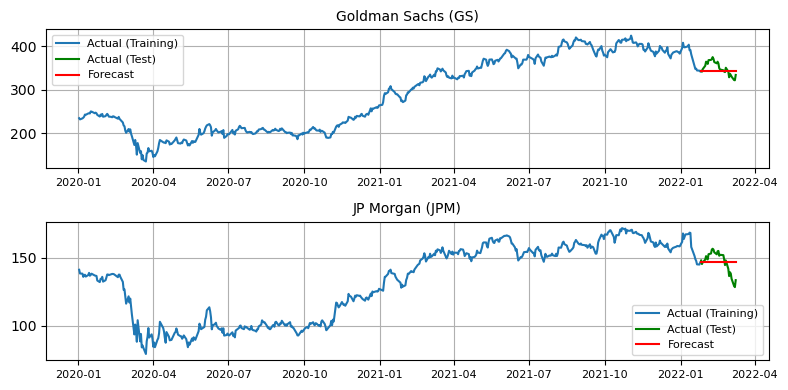

In [5]:
test_length = 30

gs_train = gs.Close[:-test_length]
jpm_train = jpm.Close[:-test_length]

gs_test = gs.Close[-test_length:]
jpm_test = jpm.Close[-test_length:]

gs_pred = gs_test.copy()
gs_pred[:] = gs_train[-1]

jpm_pred = jpm_test.copy()
jpm_pred[:] = jpm_train[-1]


gs_data = [gs_train, gs_test, gs_pred]
jpm_data = [jpm_train, jpm_test, jpm_pred]
datasets = [gs_data, jpm_data]

def plot_preds(datasets):
    names = ['Goldman Sachs (GS)', 'JP Morgan (JPM)']
    plt.style.use('default')
    fig, axs = plt.subplots(2, 1, figsize=(8,4))
    for i, (data, name) in enumerate(zip(datasets, names)):
        axs[i].set_title(name, fontsize=10)
        axs[i].plot(data[0], label='Actual (Training)')
        axs[i].plot(data[1], label='Actual (Test)', c='g')
        axs[i].plot(data[2], label='Forecast', c='r')
        axs[i].set_xticklabels(axs[i].get_xticks(), fontsize=8)
        axs[i].xaxis.set_major_formatter(date_format)
        axs[i].grid()
        axs[i].legend(fontsize=8)

    plt.tight_layout()
    
plot_preds(datasets)

In [6]:
# functions to calculate metrics for prediction evaluation
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/np.abs(y_true))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def generate_metrics(y_true, y_pred):
    return rmse(y_true, y_pred), mape(y_true, y_pred)

In [7]:
# store results
forecast_agg_results = pd.DataFrame(columns=['Ticker', 'Method', 'RMSE', 'MAPE'])

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['GS', 'Naive Baseline', *generate_metrics(gs_test, gs_pred)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['JPM', 'Naive Baseline', *generate_metrics(jpm_test, jpm_pred)])
        ),
    ignore_index=True
)

#### 4. Checking the properties of the times series

It is a prerequisite for most of the time series models that the dataset (i.e. the time series) is stationary; that is, its key statistical properties, in particular, its mean, variance, and autocorrelation are stable and do not change over time.

The reason for this is that modelling involves estimating parameters, and in case of a non-stationary time series, these parameters are different at each point in time. This leads to an explosion in the number of parameters to estimate, and so it becomes very difficult to model (and interpret the results).

By plotting autocorrelations as well as the moving average of daily closing prices, it becomes evident that neither GS nor JPM can be described as stationary. They both exhibit changing (i.e. not time-invariant) means and significant autocorrelation.

One way to tackle this problem is through transforming the time series into a stationary series by calculating differences; in particular, first differences i.e. $\Delta y_t=y_t - y_{t-1}$. If necessary, we can calculate second or higher differences, too.

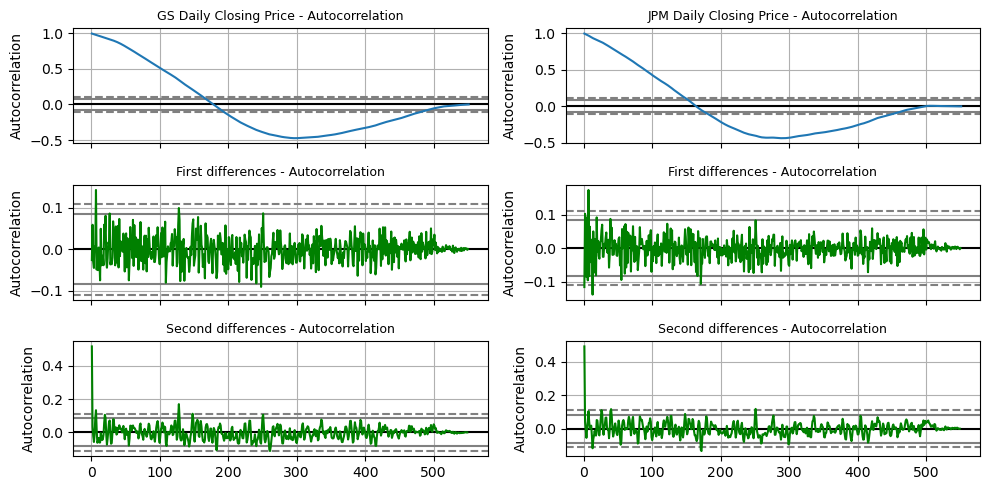

In [8]:
# autocorrelation
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10, 5))
axs = axs.flatten()

names = ['GS', 'JPM']
ts_data = [gs, jpm]
idxs = [[0, 2, 4], [1, 3, 5]]

for name, ts, idx in zip(names, ts_data, idxs):
    autocorrelation_plot(ts.Close, ax=axs[idx[0]])
    axs[idx[0]].set_title(f'{name} Daily Closing Price - Autocorrelation', fontsize=9)
    autocorrelation_plot(ts.Close.diff(1).iloc[1:], color='g', ax=axs[idx[1]])
    axs[idx[1]].set_title('First differences - Autocorrelation', fontsize=9)
    autocorrelation_plot(ts.Close.diff(2).iloc[2:], color='g', ax=axs[idx[2]])
    axs[idx[2]].set_title('Second differences - Autocorrelation', fontsize=9)

for i in range(6):
    axs[i].set_xlabel('')
plt.tight_layout()

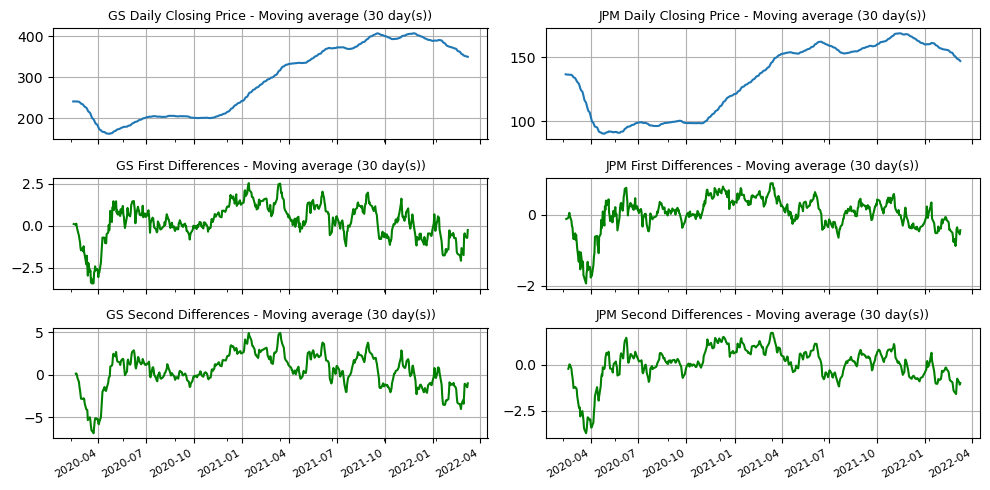

In [9]:
# moving average
window_size = 30

fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10, 5))
axs = axs.flatten()

axs[0].set_title(
    f'GS Daily Closing Price - Moving average ({window_size} day(s))',
    fontsize=9
)
axs[1].set_title(
    f'JPM Daily Closing Price - Moving average ({window_size} day(s))',
    fontsize=9
)

axs[2].set_title(
    f'GS First Differences - Moving average ({window_size} day(s))',
    fontsize=9
)
axs[3].set_title(
    f'JPM First Differences - Moving average ({window_size} day(s))',
    fontsize=9
)

axs[4].set_title(
    f'GS Second Differences - Moving average ({window_size} day(s))',
    fontsize=9
)
axs[5].set_title(
    f'JPM Second Differences - Moving average ({window_size} day(s))',
    fontsize=9
)

gs.Close.rolling(window_size).mean().plot(ax=axs[0])
jpm.Close.rolling(window_size).mean().plot(ax=axs[1])
gs.Close.diff(1).iloc[1:].rolling(window_size).mean().plot(ax=axs[2], c='g')
jpm.Close.diff(1).iloc[1:].rolling(window_size).mean().plot(ax=axs[3], c='g')
gs.Close.diff(2).iloc[2:].rolling(window_size).mean().plot(ax=axs[4], c='g')
jpm.Close.diff(2).iloc[2:].rolling(window_size).mean().plot(ax=axs[5], c='g')

for i in range(6):
    axs[i].set_xticklabels(axs[i].get_xticks(), fontsize=8)
    axs[i].xaxis.set_major_formatter(date_format)
    axs[i].grid()
    axs[i].set_xlabel('')
    
plt.tight_layout()

The autocorrelation plot clearly demonstrates that by taking first differences we managed to reduce the size of autocorrelation for both GS and JPM and for almost all lags. Taking second differences, however, creates a significant spike at the front end, which indicates over-differencing, hence that is not the preferred option.

We can observe significant improvement on the moving average front as well. The means look a lot more stable with the exception of the COVID-induced shock in the front end.

In order to validate that first differencing indeed resulted in a stationary series, we can apply statistical tests. The one implemented below is called Augmented Dickey-Fuller (ADF) test, whose null hypothesis is that the time series is non-stationary.

For both GS and JPM, we can see that the ADF test returns very small p_values for the first differences allowing us to reject the null hypothesis and conclude that they are indeed stationary series.

In [10]:
def interpret_adf_results(p_val, threshold=0.05):
    if p_val >= threshold:
        return (f'not enough evidence to reject the null-hypothesis p_value:{p_val:.2f}')
    else:
        return (f'null-hypothesis rejected p_value:{p_val:.2f}')
    
# Original closing prices
for stock, name in zip([gs, jpm], ['GS', 'JPM']):
    _, p_value, *_ = adfuller(stock.Close)
    print(f'{name} - daily closing prices: {interpret_adf_results(p_value)}')
    
    _, p_value, *_ = adfuller(stock.Close.diff(1).iloc[1:])
    print(f'{name} - first differences: {interpret_adf_results(p_value)}', end='\n\n')

GS - daily closing prices: not enough evidence to reject the null-hypothesis p_value:0.77
GS - first differences: null-hypothesis rejected p_value:0.00

JPM - daily closing prices: not enough evidence to reject the null-hypothesis p_value:0.65
JPM - first differences: null-hypothesis rejected p_value:0.00



#### 5. Autoregressive Model (AR)

By applying this model, we forecast values using a linear combination of previous values of the same variable. In its most simplest form, AR(1) or first order AR, we use only one exaplantory variable, the previous value of the variable.

AR(1): $y_t =\mu+\phi y_{t-1}+\epsilon_t$, where $\mu$ is the mean and $\epsilon$ is white noise.

Higher order AR models add further explanatory variables in the form of more lagged values and $\phi$ parameters.

Determining which level of order (p) to use can be done multiple ways; one of them is by leveraging the partial autocorrelation (PACF) plot to find lags where PACF cuts off after lag p. In our case, PACF does not really show very significant partial autocorrelations at any lags, which indicates the presence of a random walk-like behaviour. Thus, if we cannot gain much by selecting higher order models, let us keep it simple and select AR(1) for both GS and JPM.

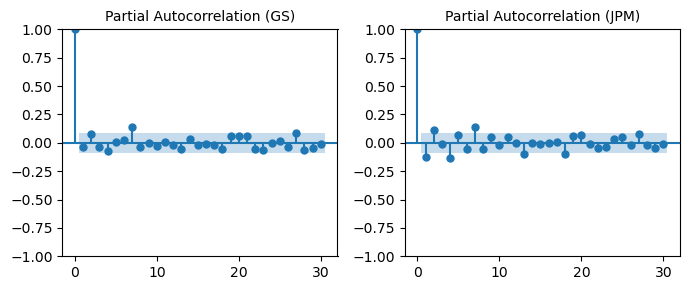

In [11]:
gs_diff_train = gs.Close.diff(1)[:-test_length]
jpm_diff_train = jpm.Close.diff(1)[:-test_length]

gs_diff_test = gs.Close.diff(1)[-test_length:]
jpm_diff_test = jpm.Close.diff(1)[-test_length:]

from statsmodels.graphics.tsaplots import plot_pacf
fig, axs = plt.subplots(1, 2, figsize=(7,3))
plot_pacf(gs_diff_train.iloc[1:], lags=30, alpha=0.05, method='ywm', ax=axs[0]);
plot_pacf(jpm_diff_train.iloc[1:], lags=30, alpha=0.05, method='ywm', ax=axs[1]);
axs[0].set_title('Partial Autocorrelation (GS)', fontsize=10)
axs[1].set_title('Partial Autocorrelation (JPM)', fontsize=10)
plt.tight_layout()

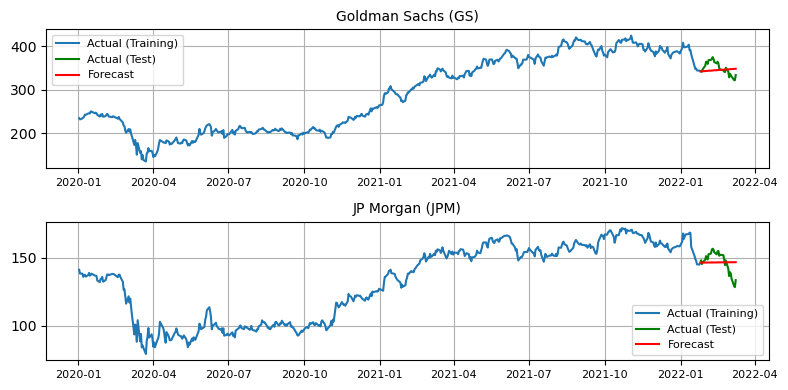

In [12]:
# GS - AR(1)
ar_model = ARIMA(gs_diff_train.iloc[1:], order=(1, 0, 0))
results = ar_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(gs_diff_test.index.values)
gs_pred_ar = pred['mean'].cumsum() + gs_train[-1]

# JPM - AR(1)
ar_model = ARIMA(jpm_diff_train.iloc[1:], order=(1, 0, 0))
results = ar_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(jpm_diff_test.index.values)
jpm_pred_ar = pred['mean'].cumsum() + jpm_train[-1]

# plot predictions vs actual values
gs_data = [gs_train, gs_test, gs_pred_ar]
jpm_data = [jpm_train, jpm_test, jpm_pred_ar]
datasets = [gs_data, jpm_data]
plot_preds(datasets)

#### 6. Moving Average Model (MA)

Like the AR model, the MA model also leverages linear combination; here, however, the explanatory variables are the previous shock terms (white noise) and not those of the predicted variable. In its most simplest form, MA(1) or first order MA, we use only one exaplantory variable, the shock at the previous step.

MA(1): $y_t =\mu+\epsilon_t+\phi \epsilon_{t-1}$, where $\mu$ is the mean and $\epsilon$ is white noise.

Higher order MA models add further explanatory variables in the form of more lagged values and $\phi$ parameters.

Determining which level of order (q) to use can be done multiple ways; one of them is by leveraging the autocorrelation (ACF) plot to find lags where ACF cuts off after lag q. In our case, ACF does not really show very significant partial autocorrelations at any lags, which indicates the presence of a random walk-like behaviour. Again, keep it simple and select MA(1) for both GS and JPM.

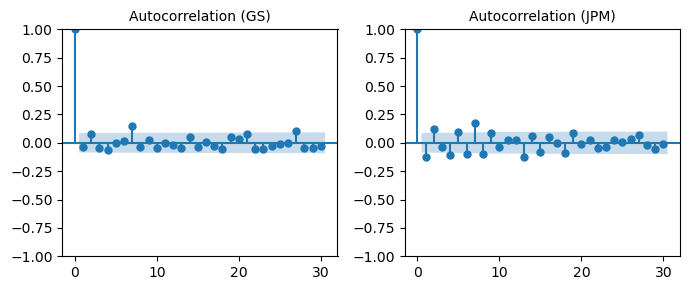

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
plot_acf(gs_diff_train.iloc[1:], lags=30, alpha=0.05, ax=axs[0]);
plot_acf(jpm_diff_train.iloc[1:], lags=30, alpha=0.05, ax=axs[1]);
axs[0].set_title('Autocorrelation (GS)', fontsize=10)
axs[1].set_title('Autocorrelation (JPM)', fontsize=10)
plt.tight_layout()

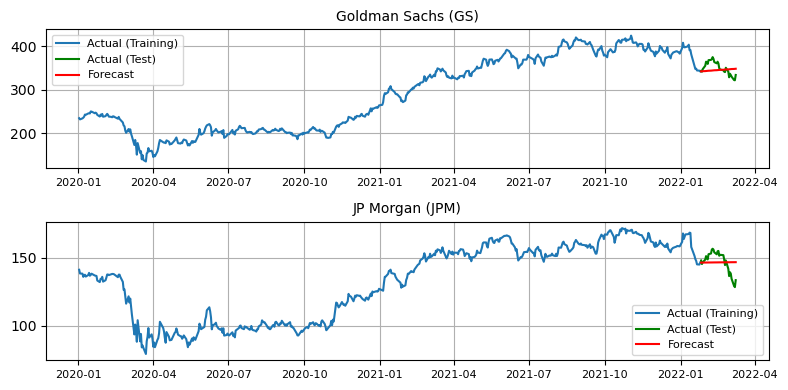

In [14]:
# GS - MA(1)
ma_model = ARIMA(gs_diff_train.iloc[1:], order=(0, 0, 1))
results = ma_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(gs_diff_test.index.values)
gs_pred_ma = pred['mean'].cumsum() + gs_train[-1]

# JPM - MA(1)
ma_model = ARIMA(jpm_diff_train.iloc[1:], order=(0, 0, 1))
results = ma_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(jpm_diff_test.index.values)
jpm_pred_ma = pred['mean'].cumsum() + jpm_train[-1]

# plot predictions vs actual values
gs_data = [gs_train, gs_test, gs_pred_ma]
jpm_data = [jpm_train, jpm_test, jpm_pred_ma]
datasets = [gs_data, jpm_data]
plot_preds(datasets)

#### 7. ARMA model

The ARMA model combines the previously discussed AR and MA models. Instead of just simply setting their orders to be 1 just as we did earlier, now let us try to find the best model by iterating over a few possible (p,q) combinations and selecting the one with the smallest AIC, which is one of the methods to evaluate how well a given model fits the data.

In [15]:
p = range(9) # AR component
d = range(1) # Integrated component - not used, so d is always 0
q = range(9) # MA component

# generate all different p/d/q combinations
pdq = list(product(p, d, q))

aic= []
parameters = []

# iterate over possible parameter setups
for params in pdq:
    arma_model = ARIMA(gs_diff_train.iloc[1:], order=params)
    results = arma_model.fit()
    aic.append(results.aic)
    parameters.append(params)
    
# optimal model
best_params = parameters[np.argmin(aic)]
print('Optimal model for GS: ARIMA({}, {}, {}), AIC: {:.2f}'.format(*best_params, min(aic)))

# iterate over possible parameter setups
for params in pdq:
    arma_model = ARIMA(jpm_diff_train.iloc[1:], order=params)
    results = arma_model.fit()
    aic.append(results.aic)
    parameters.append(params)
    
# optimal model
best_params = parameters[np.argmin(aic)]
print('Optimal model for JPM: ARIMA({}, {}, {}), AIC: {:.2f}'.format(*best_params, min(aic)))

Optimal model for GS: ARIMA(4, 0, 4), AIC: 3329.57
Optimal model for JPM: ARIMA(4, 0, 4), AIC: 2534.51


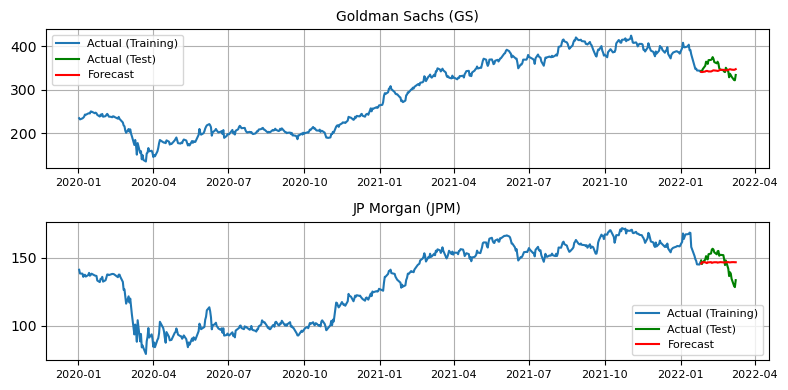

In [16]:
# GS - ARMA(4, 4)
arma_model = ARIMA(gs_diff_train.iloc[1:], order=(4, 0, 4))
results = arma_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(gs_diff_test.index.values)
gs_pred_arma = pred['mean'].cumsum() + gs_train[-1]

# JPM - MA(4, 4)
arma_model = ARIMA(jpm_diff_train.iloc[1:], order=(4, 0, 4))
results = arma_model.fit()
pred = results.get_forecast(steps=test_length).summary_frame()
pred = pred.set_index(jpm_diff_test.index.values)
jpm_pred_arma = pred['mean'].cumsum() + jpm_train[-1]

# plot predictions vs actual values
gs_data = [gs_train, gs_test, gs_pred_arma]
jpm_data = [jpm_train, jpm_test, jpm_pred_arma]
datasets = [gs_data, jpm_data]
plot_preds(datasets)

**Aggregating results (AR, MA, ARMA)**

In [17]:
forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['GS', 'AR(1)', *generate_metrics(gs_test, gs_pred_ar)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['JPM', 'AR(1)', *generate_metrics(jpm_test, jpm_pred_ar)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['GS', 'MA(1)', *generate_metrics(gs_test, gs_pred_ma)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['JPM', 'MA(1)', *generate_metrics(jpm_test, jpm_pred_ma)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['GS', 'ARMA(4,4)', *generate_metrics(gs_test, gs_pred_arma)])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['JPM', 'ARMA(4,4)', *generate_metrics(jpm_test, jpm_pred_arma)])
        ),
    ignore_index=True
)

We must conclude that applying these basic time series forecasting methods failed to substantially improve the prediction results relative to the naive baseline estimates. In fact, it is only in case of GS and only with respect to RMSE that AR(1) and MA(1) models could marginally improve the results. In all other cases, the Naive Baseline estimate turned out to be the best one from both an RMSE and MAPE perspective.

One thing to note here is that the results heavily depend on the dates selected. By setting the end date of the training part of the time series to be at the beginning of October, for example, all models perform better than the baseline estimate.

In [18]:
forecast_agg_results[forecast_agg_results.Ticker == 'GS'].sort_values('RMSE').reset_index(drop=True)

,Ticker,Method,RMSE,MAPE
0,GS,AR(1),16.949316,0.040598
1,GS,MA(1),16.951110,0.040602
2,GS,Naive Baseline,17.018496,0.039149
3,GS,"ARMA(4,4)",17.179098,0.041129


In [19]:
forecast_agg_results[forecast_agg_results.Ticker == 'JPM'].sort_values('RMSE').reset_index(drop=True)

,Ticker,Method,RMSE,MAPE
0,JPM,Naive Baseline,8.004688,0.046264
1,JPM,MA(1),8.066710,0.046655
2,JPM,AR(1),8.067761,0.046696
3,JPM,"ARMA(4,4)",8.078853,0.046829


#### 8. Linear Regression / Elastic Net

Given the lucklustre results provided by AR, MA and ARMA, let us consider applying another method - linear regression.


Due to the trajectory of the time series, it is quite evident that a simple linear regression would perform poorly, so let us introduce some curvature by adding polynomial features.


Polynomial regressions, especially with large degrees, are likely to overfit, so instead of the basic Linear Regression model, I used the ElasticNet model, which introduces regularisation into the equation. Instead of manually trying to find the best hyperparameters for this model, I leveraged GridSearchCV that creates multiple models and selects the best performing one.

In [20]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.model_selection import TimeSeriesSplit

# Create pipeline with poly features and ElasticNet model
pipe = make_pipeline(PolynomialFeatures(), ElasticNet())

param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'elasticnet__alpha': [0, 0.01, 0.1, 1, 5, 10, 100],
    'elasticnet__l1_ratio': [0, 0.1, 0.5, 0.9, 1]
}

gscv_gs = GridSearchCV(pipe, param_grid=param_grid)
gscv_jpm = GridSearchCV(pipe, param_grid=param_grid)

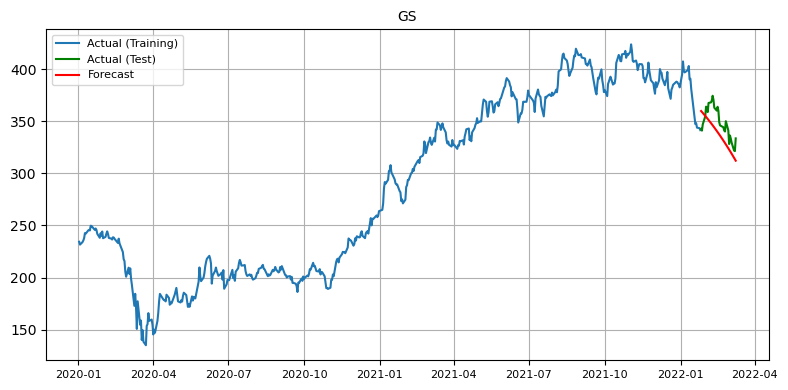

In [21]:
# convert dates (explanatory variable) to indicate number of days since the first day of the period (training set)
X = (gs_train.index - gs.Close.index[0]).days.to_numpy().reshape(-1, 1)
y = gs_train.values
model_gs = gscv_gs.fit(X, y)

# same conversion as above, now for the test set
gs_test_reshaped = (gs_test.index - gs.Close.index[0]).days.to_numpy().reshape(-1, 1)

plt.style.use('default')
fig, axs = plt.subplots(1, 1, figsize=(8,4))

axs.set_title('GS', fontsize=10)
axs.plot(gs_train, label='Actual (Training)')
axs.plot(gs_test, label='Actual (Test)', c='g')
axs.plot(gs_test.index, model_gs.predict(gs_test_reshaped), label='Forecast', c='r')
axs.set_xticklabels(axs.get_xticks(), fontsize=8)
axs.xaxis.set_major_formatter(date_format)
axs.grid()
axs.legend(fontsize=8)

plt.tight_layout()

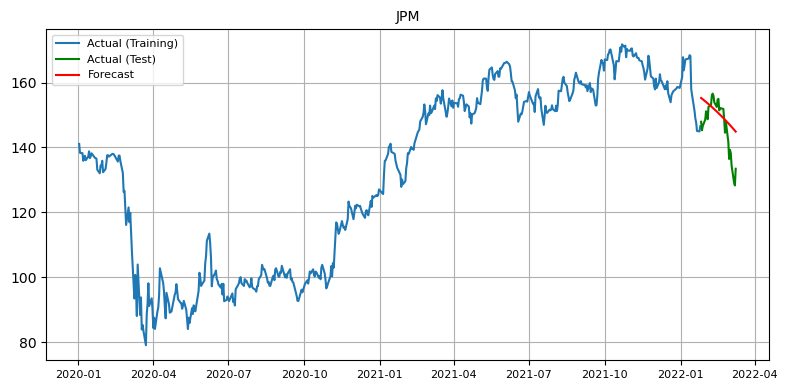

In [22]:
# convert dates (explanatory variable) to indicate number of days since the first day of the period (training set)
X = (jpm_train.index - jpm.Close.index[0]).days.to_numpy().reshape(-1, 1)
y = jpm_train.values
model_jpm = gscv_jpm.fit(X, y)

# same conversion as above, now for the test set
jpm_test_reshaped = (jpm_test.index - jpm.Close.index[0]).days.to_numpy().reshape(-1, 1)

plt.style.use('default')
fig, axs = plt.subplots(1, 1, figsize=(8,4))

axs.set_title('JPM', fontsize=10)
axs.plot(jpm_train, label='Actual (Training)')
axs.plot(jpm_test, label='Actual (Test)', c='g')
axs.plot(jpm_test.index, model_jpm.predict(jpm_test_reshaped), label='Forecast', c='r')
axs.set_xticklabels(axs.get_xticks(), fontsize=8)
axs.xaxis.set_major_formatter(date_format)
axs.grid()
axs.legend(fontsize=8)

plt.tight_layout()

In [23]:
# add results
forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['GS', 'ElasticNet', *generate_metrics(gs_test, model_gs.predict(gs_test_reshaped))])
        ),
    ignore_index=True
)

forecast_agg_results = forecast_agg_results.append(
    dict(zip(
            forecast_agg_results.columns,
            ['JPM', 'ElasticNet', *generate_metrics(jpm_test, model_jpm.predict(jpm_test_reshaped))])
        ),
    ignore_index=True
)

We can see that ElasticNet provides superior results relative to all previous models when using RMSE to evaluate performance.

In [24]:
forecast_agg_results[forecast_agg_results.Ticker == 'GS'].sort_values('RMSE').reset_index(drop=True)

,Ticker,Method,RMSE,MAPE
0,GS,ElasticNet,16.283532,0.042236
1,GS,AR(1),16.949316,0.040598
2,GS,MA(1),16.951110,0.040602
3,GS,Naive Baseline,17.018496,0.039149
4,GS,"ARMA(4,4)",17.179098,0.041129


In [25]:
forecast_agg_results[forecast_agg_results.Ticker == 'JPM'].sort_values('RMSE').reset_index(drop=True)

,Ticker,Method,RMSE,MAPE
0,JPM,ElasticNet,7.098413,0.039451
1,JPM,Naive Baseline,8.004688,0.046264
2,JPM,MA(1),8.066710,0.046655
3,JPM,AR(1),8.067761,0.046696
4,JPM,"ARMA(4,4)",8.078853,0.046829


Note, however, that models are using 4th and 3rd degree polynomial features, which means that they probably still overfit. In fact, applying TS-specific cross validation (i.e. TimeSeriesSplit, cv=5) leads to less complexity (degree=2) and much poorer results, so we should keep fine tuning these models, trying out new ones, and adding exogenous variables for better results.

In [26]:
print(model_gs.best_params_['polynomialfeatures__degree'], model_jpm.best_params_['polynomialfeatures__degree'])

4 3
